# 论坛用户的地区和行业分布情况

In [1]:
from model import Users, Posts, Replies, Topics, TopicUser, Provs, Industry

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

> 假装自己在写`R`，这里设置了图像风格为`ggplot`。可以在[Matplotlib Style Gallery][gallery]中查看`matplotlib`生成图表的风格样式

[gallery]: https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html


### 从数据库中取出数据

从users、provs、industry三张表中分别取出用户、地区和行业数据

In [2]:
u = (Users.select(Users.id, Users.prov, Users.industry, Users.linkname,
                  Users.level, Users.prestige, Users.approve, 
                  Users.thank, Users.visits, Users.last_signin_at))
p = Provs.select()
i = Industry.select()

### 利用pandas处理数据

将取出的用户，地区和行业分别转换为*大名鼎鼎的`pandas`中的大名鼎鼎的`dataframe`*

为了方便后面进行merge和演示如何重命名列，这里在构造dataframe的时候把用户表中的`prov`和省份表中的`id`改成相同的名称

In [3]:
udf = pd.DataFrame(list(u.dicts())).set_index('id').sort_index().rename({'prov': 'prov_id'}, axis=1)
pdf = pd.DataFrame(list(p.dicts())).rename({'id': 'prov_id'}, axis=1)
idf = pd.DataFrame(list(i.dicts()))

### 处理地区数据

获取用户地区分布情况

`pandas`的`merge`完全等于sql中的`join`，参数`on`就是我们需要合并的列，其实还有一个隐藏的参数`how`，用来指定`merge`的行为，它和SQL对比如下表

|how   | SQL              |
|------|------------------|
|left  | LEFT OUTER JOIN  |
|right | RIGHT OUTER JOIN |
|outer | FULL OUTER JOIN  |
|inner | INNER JOIN       |


In [4]:
loc = pd.merge(udf, pdf, on='prov_id')
loc.tail()

,approve,industry,last_signin_at,level,linkname,prestige,prov_id,thank,visits,prov
91036,0.0,NaN,2018-01-05 23:12,2.0,jasonieong,0.0,3.13317e+07,0.0,43.0,澳门
91037,0.0,78084629.0,None,2.0,lnubiofox,0.0,3.13317e+07,0.0,3.0,澳门
91038,0.0,24007669.0,None,2.0,kakaemma,0.0,3.13317e+07,0.0,4.0,澳门
91039,0.0,91289692.0,2018-01-11 15:23,2.0,lwbleach,0.0,3.13317e+07,0.0,0.0,澳门
91040,0.0,88330098.0,2017-12-01 03:34,2.0,Augusto,0.0,3.13317e+07,0.0,4.0,澳门


> 其实之前不用改名也可以顺利进行`merge`，后面在分析行业时再进行展示

下面稍稍复杂一点，这里将pandas的语句翻译成SQL来便于理解，例如`loc.groupby(['prov']).size()`翻译过去就是`SELECT prov, COUNT(prov) FROM loc GROUP BY prov`，
不过这里返回的数据类型不是`dataframe`，而是`series`，然后我们用`reset_index(name='counts')`将其转化为`dataframe`并给这一列起了一个名字叫`counts`，最后再按照`counts`来个逆序排序。于是，这一整行翻译成SQL就变成了`SELECT prov, COUNT(prov) AS counts FROM loc GROUP BY prov ORDER BY counts desc`

数据中混进了三个奇怪的东西，需要丢掉它们，最后用省份作为索引再预览一下

In [5]:
dis_loc = loc.groupby(['prov']).size().reset_index(name='counts').sort_values('counts', ascending=False)
dis_loc = dis_loc.drop([0, 1, 2])
dis_loc = dis_loc.set_index('prov')
dis_loc.head()

,counts
prov,
广东省,16650
上海市,14347
北京市,13823
浙江省,7127
江苏省,6773


### 用matplotlib画出饼图

`pandas`和`matplotlib`结合的是如此的紧密，*数据准备好*之后一个不错的图像就出来了

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bb492e8>], dtype=object)

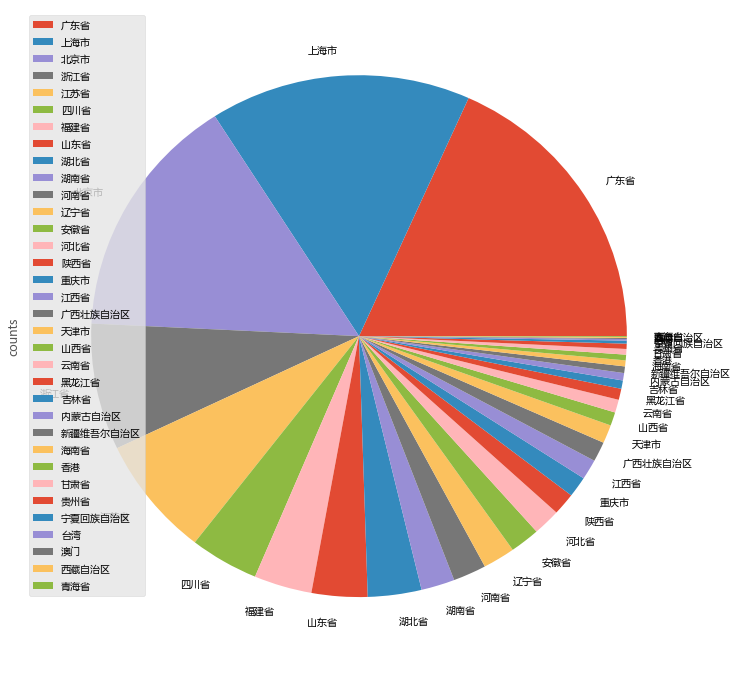

In [6]:
dis_loc.plot.pie(figsize=(12, 12), subplots=True)

> 没想到广东居然是论坛第一大的群体，更没想到的是北上广（东）居然占据了半壁江山

### Mac系统中matplotlib显示中文的方法

以微软雅黑为例，微软雅黑的字体名为`Microsoft YaHei`
1. 拷贝中文字体至`~/Library/Fonts/`
4. 删除`~/.matplotlib`下所有文件（经验证`fontList.json`也是要删的）
3. 在代码中加入如下内容即可
```python
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
```

也可修改`~/.matplotlib//matplotlibrc`中相关选项一劳永逸的解决问题，不再赘述。

如果目录下没有这个文件，运行下面的代码可以找到对应文件
```python
import matplotlib
print(matplotlib.matplotlib_fname())
```


## 行业分布情况

做完了地区分布情况，行业分布就是依样画葫芦

之前在处理`dataframe时，`没有对用户的`industry`外键字段改名，那么在合并时可以分别指定左右两表需要进行`merge`的列

In [7]:
ind = pd.merge(udf, idf, left_on='industry', right_on='id')
ind.head()

,approve,industry_x,last_signin_at,level,linkname,prestige,prov_id,thank,visits,id,industry_y
0,13508.0,8.83301e+07,2018-01-26 22:40,0.0,天书,2514.0,NaN,1740.0,642698.0,88330098,金融/银行/保险/证券/投资
1,0.0,8.83301e+07,2014-02-17 21:22,2.0,ieso,0.0,NaN,0.0,7618.0,88330098,金融/银行/保险/证券/投资
2,18.0,8.83301e+07,2017-12-11 09:13,1.0,linker9,13.0,33499672.0,10.0,2219.0,88330098,金融/银行/保险/证券/投资
3,4.0,8.83301e+07,2014-01-30 14:06,2.0,whsimon,3.0,NaN,0.0,1204.0,88330098,金融/银行/保险/证券/投资
4,0.0,8.83301e+07,2018-01-19 13:44,2.0,wangzhiyong,0.0,21538966.0,0.0,594.0,88330098,金融/银行/保险/证券/投资


> 可以看到合并完成后出现了两个特殊的列`industry_x`和`industry_y`,参照上面合并省份的例子，不难理解

之后的处理过程和上面并无二致

In [8]:
dis_ind = ind.groupby('industry_y').size().reset_index(name='counts').sort_values('counts', ascending=True)
dis_ind = dis_ind.set_index('industry_y')
dis_ind.sort_values('counts', ascending=False).head()

,counts
industry_y,
金融/银行/保险/证券/投资,20380
其他,10240
计算机软、硬件/互联网/IT,10052
销售,4353
财会/审计/统计,3373


### 用matplotlib画直方图

这里选择用横向直方图来展示行业分布情况，画图函数的写法稍稍不同，其实效果是一样的。

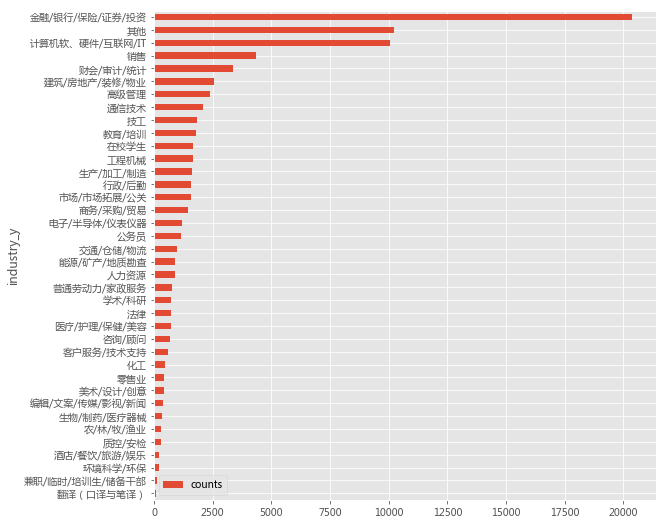

In [9]:
dis_ind.plot(kind='barh', figsize=(9, 9))

### 北上广用户的城市（区）分布情况

上面看到了论坛里用户大约一半在北上广地区，现在就来看看北上广地区用户的具体分布情况

In [10]:
uu = (Users.select(Provs.prov, Users.locate, Users.id)
      .join(Provs, on=(Users.prov==Provs.id))
      .where(Users.locate.is_null(False)))

> 这里直接用了数据库提供的`join`，免去读两张表再`merge`一遍

下面加入了一列`ratio`，用来显示该地区用户占总用户数的百分比，最后显示排名前10的地区

In [11]:
uudf = pd.DataFrame(list(uu.dicts()))
uudf = uudf.groupby(['prov', 'locate']).size().reset_index(name='counts')
uudf = uudf.drop([0, 1, 2])
uudf['ratio'] =  (uudf['counts'] / uudf['counts'].sum()).map(lambda n: '{:,.2%}'.format(n))  
uudf.sort_values('counts', ascending=False).head(10)

,prov,locate,counts,ratio
185,广东省,深圳市,5784,7.55%
177,广东省,广州市,5327,6.95%
13,上海市,浦东新区,4446,5.80%
61,北京市,朝阳区,3404,4.44%
279,浙江省,杭州市,3310,4.32%
93,四川省,成都市,2607,3.40%
62,北京市,海淀区,2528,3.30%
223,江苏省,南京市,1958,2.55%
293,湖北省,武汉市,1909,2.49%
233,江苏省,苏州市,1528,1.99%


然后分别算出北上广地区的具体情况，最后用`concat`把三张表拼接在一起，直观感受一下论坛三大势力的地区细分排名

In [12]:
bj = uudf.loc[uudf['prov'] == '北京市']
sh = uudf.loc[uudf['prov'] == '上海市']
gd = uudf.loc[uudf['prov'] == '广东省']

bsg = pd.concat([bj, sh, gd]).sort_values('counts', ascending=False)

bsg.head(10)

,prov,locate,counts,ratio
185,广东省,深圳市,5784,7.55%
177,广东省,广州市,5327,6.95%
13,上海市,浦东新区,4446,5.80%
61,北京市,朝阳区,3404,4.44%
62,北京市,海淀区,2528,3.30%
64,北京市,西城区,1201,1.57%
9,上海市,徐汇区,924,1.21%
176,广东省,佛山市,873,1.14%
173,广东省,东莞市,846,1.10%
17,上海市,闵行区,769,1.00%


> 三行几乎一样的代码让人感觉这里存在一个更简洁的写法，受制于pandas的初学阶段，先这样吧。

以北京为例，这里为了让图表能够正常显示，去掉了`ratio`列，为了让显示更直观，去掉了`prov`列，最后照例要排个序

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11337aa20>], dtype=object)

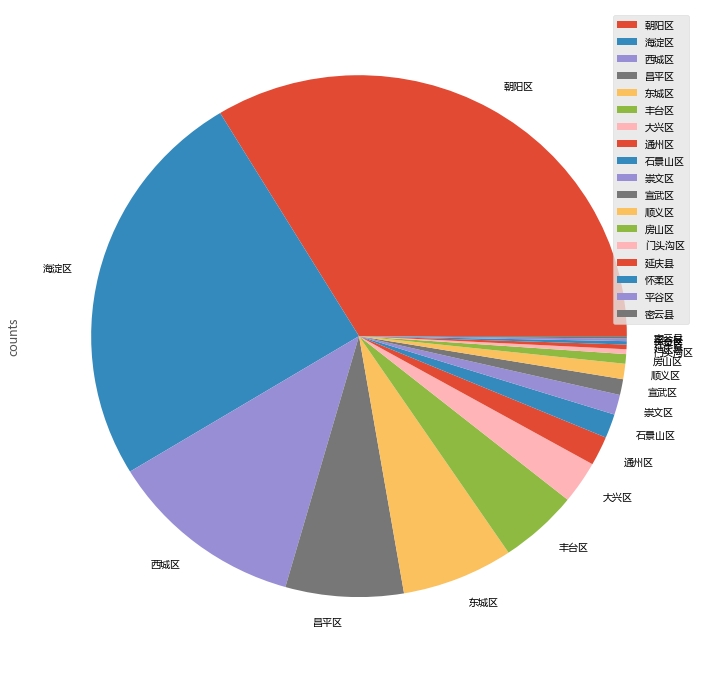

In [13]:
fig = bj.drop(['ratio', 'prov'], axis=1).groupby('locate').sum().sort_values('counts', ascending=False)
fig.plot.pie(figsize=(12, 12), subplots=True)

> 这里本来想探索用`subplots`一次生成北上广三张图的，大概是因为我对`subplots`有什么误解，最终毫无悬念的失败了